# Robustness Exploration for Image Segmentation

This notebook evaluates robustness of segmentation models using the required 8 perturbations. We'll create perturbed test sets, apply them to our best model, and visualize the results.

## 1. Setup and Imports

In [2]:
import os
import sys
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.transforms.functional as TF
from torch.utils.data import DataLoader
import matplotlib
matplotlib.rcParams['figure.figsize'] = (12, 8)


project_root = os.path.abspath(os.path.join(os.path.dirname('__file__'), '..'))
sys.path.append(project_root)

# Import our robustness evaluation module
from src.robustness_evaluation import (
    PerturbedPetDataset, 
    evaluate_model_on_perturbations,
    save_example_perturbations, 
    plot_perturbation_results,
    visualize_predictions
)

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


## 2. Configuration

In [3]:
# Set paths
DATASET_ROOT = '../Dataset_augmented/'  # Path to augmented dataset
MODEL_PATH = '../notebooks/models/unet_v7_unaugmented_dataset/unet_pet_segmentation_best.pt' # Path to best model
OUTPUT_DIR = '../robustness_results/'

# Create output directory
os.makedirs(OUTPUT_DIR, exist_ok=True)

## 3. Load Best Model

In [4]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)

# Define the UNet architecture
class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=3, features_start=32):
        super(UNet, self).__init__()
        
        # Encoder (Downsampling)
        self.encoder1 = DoubleConv(in_channels, features_start)
        self.pool1 = nn.MaxPool2d(2)
        self.encoder2 = DoubleConv(features_start, features_start*2)
        self.pool2 = nn.MaxPool2d(2)
        self.encoder3 = DoubleConv(features_start*2, features_start*4)
        self.pool3 = nn.MaxPool2d(2)
        self.encoder4 = DoubleConv(features_start*4, features_start*8)
        self.pool4 = nn.MaxPool2d(2)
        
        # Bottom
        self.bottom = DoubleConv(features_start*8, features_start*16)
        
        # Decoder (Upsampling)
        self.upconv4 = nn.ConvTranspose2d(features_start*16, features_start*8, kernel_size=2, stride=2)
        self.decoder4 = DoubleConv(features_start*16, features_start*8)
        self.upconv3 = nn.ConvTranspose2d(features_start*8, features_start*4, kernel_size=2, stride=2)
        self.decoder3 = DoubleConv(features_start*8, features_start*4)
        self.upconv2 = nn.ConvTranspose2d(features_start*4, features_start*2, kernel_size=2, stride=2)
        self.decoder2 = DoubleConv(features_start*4, features_start*2)
        self.upconv1 = nn.ConvTranspose2d(features_start*2, features_start, kernel_size=2, stride=2)
        self.decoder1 = DoubleConv(features_start*2, features_start)
        
        # Final Convolution
        self.final_conv = nn.Conv2d(features_start, out_channels, kernel_size=1)

    def forward(self, x):
        # Encoder
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool1(enc1))
        enc3 = self.encoder3(self.pool2(enc2))
        enc4 = self.encoder4(self.pool3(enc3))
        
        # Bottom
        bottom = self.bottom(self.pool4(enc4))
        
        # Decoder with skip connections
        dec4 = self.upconv4(bottom)
        dec4 = torch.cat([dec4, enc4], dim=1)
        dec4 = self.decoder4(dec4)
        
        dec3 = self.upconv3(dec4)
        dec3 = torch.cat([dec3, enc3], dim=1)
        dec3 = self.decoder3(dec3)
        
        dec2 = self.upconv2(dec3)
        dec2 = torch.cat([dec2, enc2], dim=1)
        dec2 = self.decoder2(dec2)
        
        dec1 = self.upconv1(dec2)
        dec1 = torch.cat([dec1, enc1], dim=1)
        dec1 = self.decoder1(dec1)
        
        return self.final_conv(dec1)

In [5]:
# Initialise model with the same parameters as during training
model = UNet(in_channels=3, out_channels=3, features_start=32)

# Load the checkpoint
checkpoint = torch.load(MODEL_PATH, map_location=device)

# The actual model state dictionary is under 'model_state_dict'
model.load_state_dict(checkpoint['model_state_dict'])

# Move to device and set to evaluation mode
model.to(device)
model.eval()

print("Model loaded successfully!")

print(f"Model was trained for {checkpoint['epoch']} epochs")
print(f"Final validation Dice score: {checkpoint['val_dice']}")
print(f"Final validation IoU: {checkpoint['val_iou']}")

Model loaded successfully!
Model was trained for 19 epochs
Final validation Dice score: 0.9226376811663309
Final validation IoU: 0.8586763540903727


C:\Users\dcb_r\AppData\Local\Temp\ipykernel_16304\1394805379.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(MODEL_PATH, map_location=device)


## 4. Generate Examples of Each Perturbation

Let's generate examples of each perturbation at different intensity levels. This will help us understand the visual impact of the perturbations and provide examples for the report.

In [6]:
# Directory to save example images
examples_dir = os.path.join(OUTPUT_DIR, 'examples')
os.makedirs(examples_dir, exist_ok=True)

# Save example images for all perturbations
print("Generating examples for each perturbation...")
save_example_perturbations(DATASET_ROOT, examples_dir)
print("Done generating examples!")

Generating examples for each perturbation...
Done generating examples!


Visualising the examples to understand how each perturbation affects the images at different intensity levels:

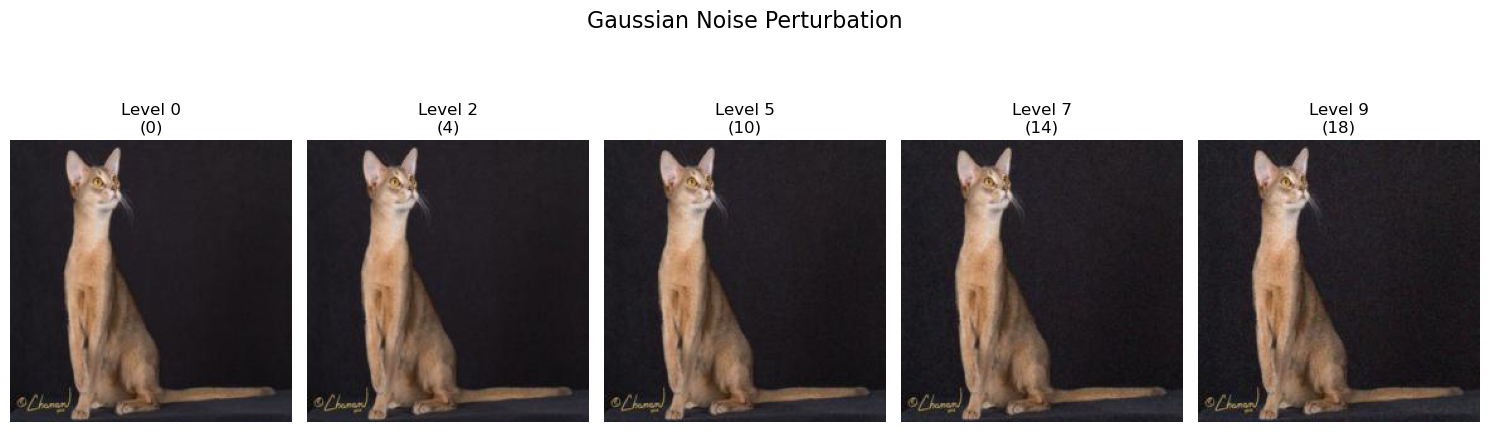

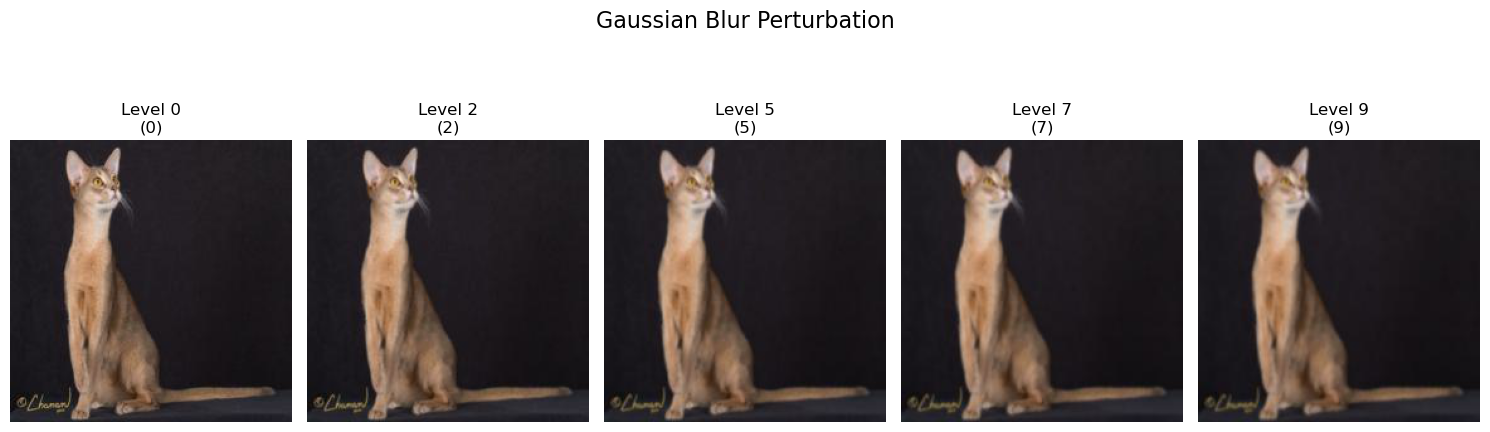

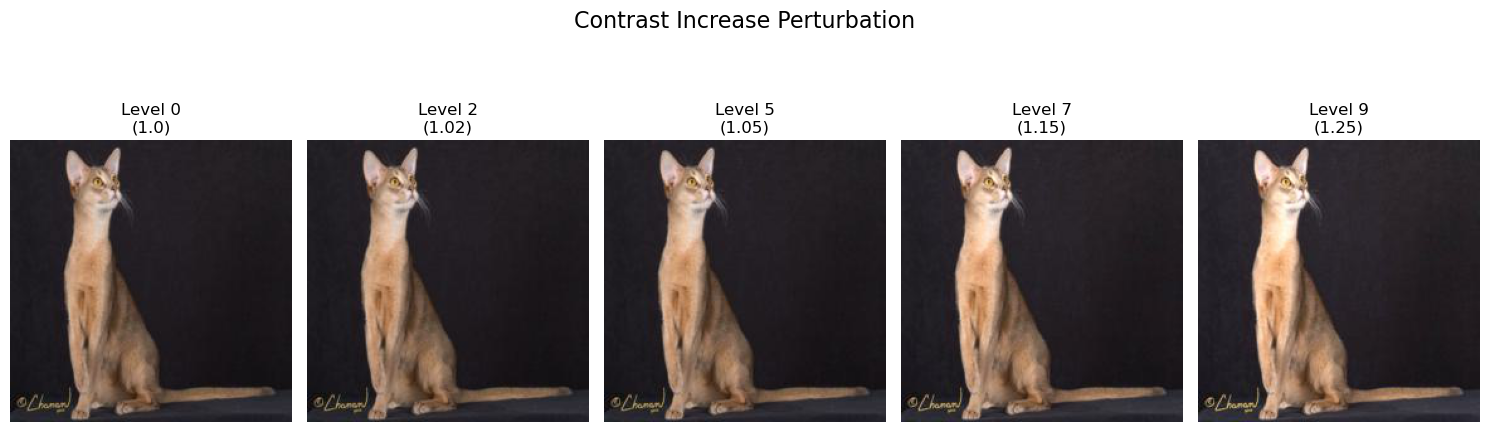

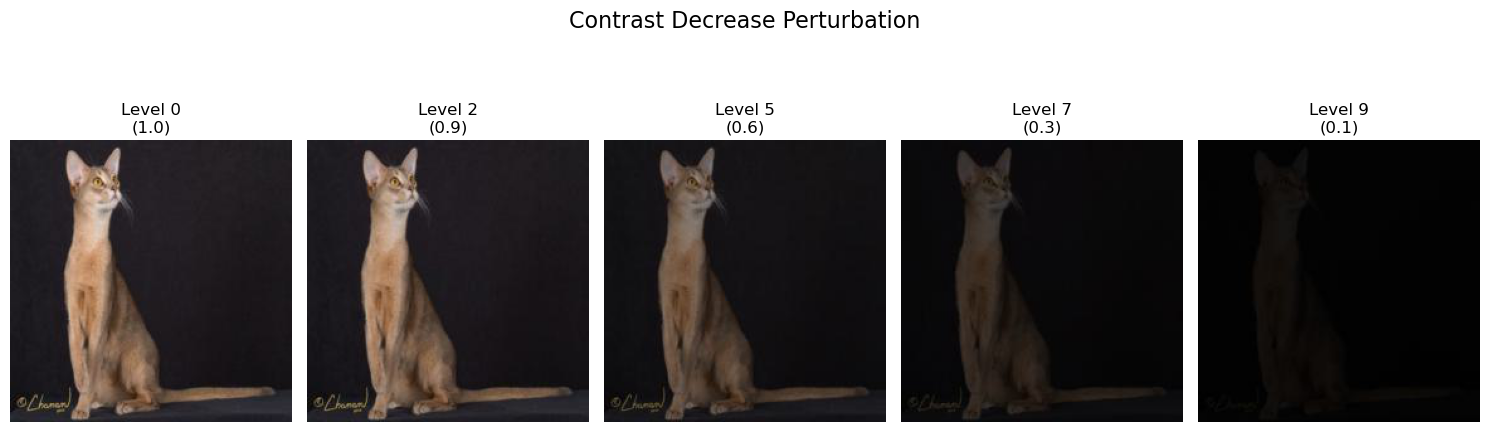

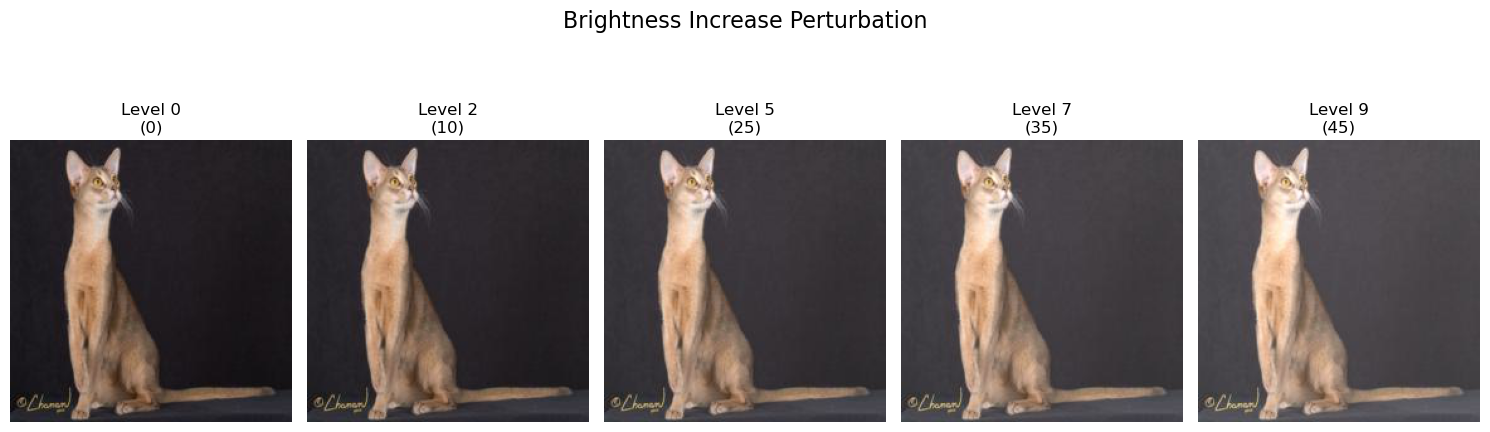

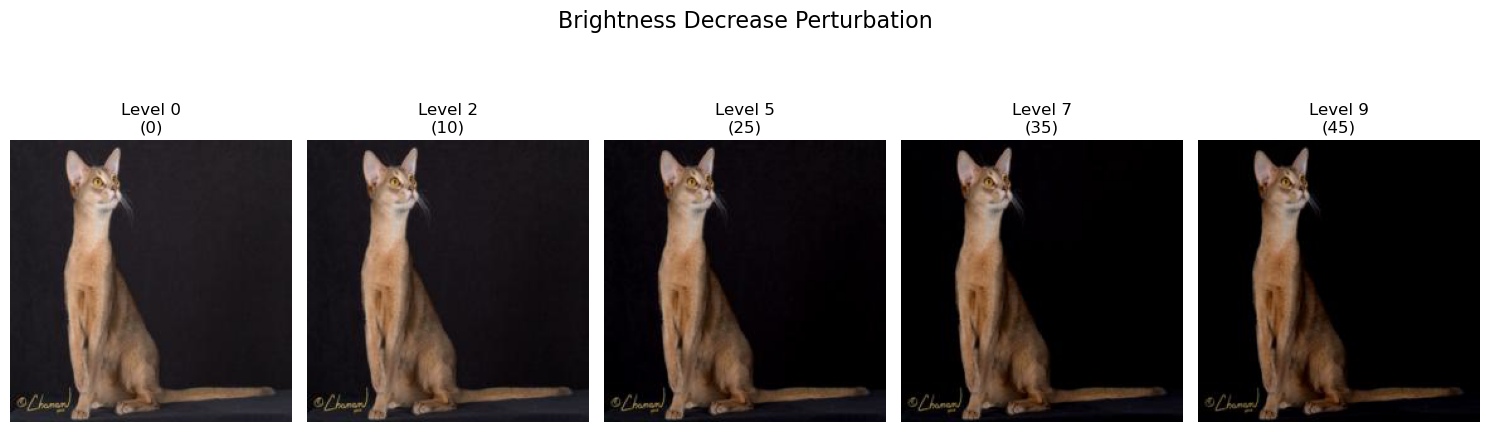

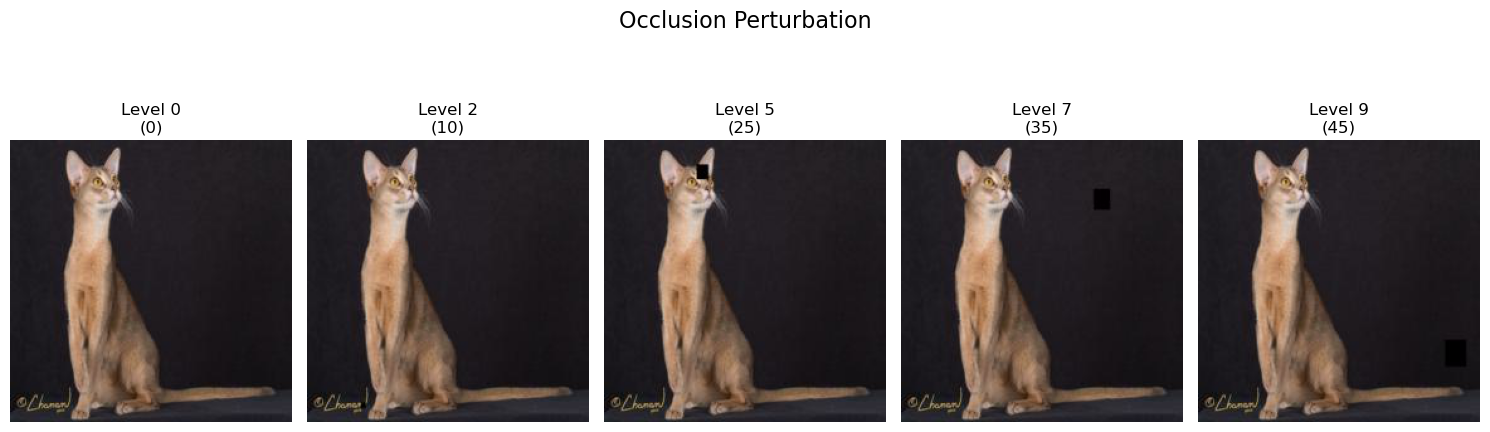

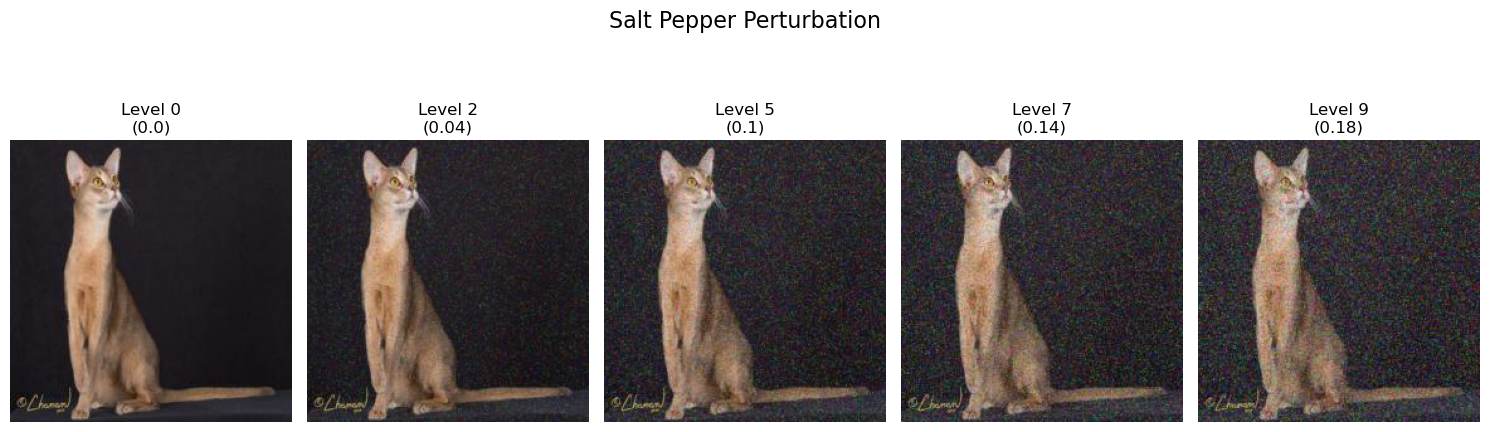

In [7]:
perturbation_types = [
    'gaussian_noise', 'gaussian_blur', 'contrast_increase', 'contrast_decrease',
    'brightness_increase', 'brightness_decrease', 'occlusion', 'salt_pepper'
]

# Get intensity values for axis labels
dummy_dataset = PerturbedPetDataset(None)
intensity_values = {p: dummy_dataset.intensity_values[p] for p in perturbation_types}

# Show examples of each perturbation at different levels
for perturbation in perturbation_types:
    plt.figure(figsize=(15, 5))
    plt.suptitle(f"{perturbation.replace('_', ' ').title()} Perturbation", fontsize=16)
    
    # Show original and 4 levels of perturbation
    levels = [0, 2, 5, 7, 9]  # Original + 4 intensity levels
    
    for i, level in enumerate(levels):
        img_path = os.path.join(examples_dir, perturbation, f"level_{level}.jpg")
        if os.path.exists(img_path):
            img = Image.open(img_path)
            
            ax = plt.subplot(1, 5, i+1)
            plt.imshow(img)
            plt.title(f"Level {level}\n({intensity_values[perturbation][level]})", fontsize=12)
            plt.axis('off')
    
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.savefig(os.path.join(OUTPUT_DIR, f"{perturbation}_examples.png"), dpi=300)
    plt.show()

## 5. Evaluate Model on All Perturbations

Now we'll evaluate our model's performance on each perturbation at all intensity levels.

In [ ]:
# Evaluate model on all perturbations
print("Evaluating model on all perturbations.")
results = evaluate_model_on_perturbations(
    model, DATASET_ROOT, device, batch_size=8
)

# Save the results for later use
np.save(os.path.join(OUTPUT_DIR, 'perturbation_results.npy'), results)
print("Evaluation complete. Results saved to", os.path.join(OUTPUT_DIR, 'perturbation_results.npy'))

Evaluating model on all perturbations.
Evaluating gaussian_noise...


Level 0: 100%|██████████| 464/464 [00:58<00:00,  7.95it/s]


  Level 0: Dice = 0.6335


Level 1: 100%|██████████| 464/464 [01:17<00:00,  6.02it/s]


  Level 1: Dice = 0.6334


Level 2: 100%|██████████| 464/464 [01:16<00:00,  6.04it/s]


  Level 2: Dice = 0.6332


Level 3: 100%|██████████| 464/464 [01:16<00:00,  6.06it/s]


  Level 3: Dice = 0.6333


Level 4: 100%|██████████| 464/464 [01:16<00:00,  6.04it/s]


  Level 4: Dice = 0.6326


Level 5: 100%|██████████| 464/464 [01:16<00:00,  6.07it/s]


  Level 5: Dice = 0.6313


Level 6: 100%|██████████| 464/464 [01:16<00:00,  6.06it/s]


  Level 6: Dice = 0.6306


Level 7: 100%|██████████| 464/464 [01:16<00:00,  6.03it/s]


  Level 7: Dice = 0.6294


Level 8: 100%|██████████| 464/464 [01:16<00:00,  6.08it/s]


  Level 8: Dice = 0.6296


Level 9: 100%|██████████| 464/464 [01:16<00:00,  6.06it/s]


  Level 9: Dice = 0.6252
Evaluating gaussian_blur...


Level 0: 100%|██████████| 464/464 [00:28<00:00, 16.27it/s]


  Level 0: Dice = 0.6335


Level 1: 100%|██████████| 464/464 [01:30<00:00,  5.10it/s]


  Level 1: Dice = 0.6325


Level 2: 100%|██████████| 464/464 [02:20<00:00,  3.29it/s]


  Level 2: Dice = 0.6312


Level 3: 100%|██████████| 464/464 [03:06<00:00,  2.49it/s]


  Level 3: Dice = 0.6293


Level 4: 100%|██████████| 464/464 [03:48<00:00,  2.03it/s]


  Level 4: Dice = 0.6272


Level 5: 100%|██████████| 464/464 [04:34<00:00,  1.69it/s]


  Level 5: Dice = 0.6232


Level 6: 100%|██████████| 464/464 [05:17<00:00,  1.46it/s]


  Level 6: Dice = 0.6206


Level 7: 100%|██████████| 464/464 [06:04<00:00,  1.27it/s]


  Level 7: Dice = 0.6177


Level 8: 100%|██████████| 464/464 [06:52<00:00,  1.13it/s]


  Level 8: Dice = 0.6146


Level 9: 100%|██████████| 464/464 [07:41<00:00,  1.01it/s]


  Level 9: Dice = 0.6119
Evaluating contrast_increase...


Level 0: 100%|██████████| 464/464 [00:28<00:00, 16.41it/s]


  Level 0: Dice = 0.6335


Level 1: 100%|██████████| 464/464 [00:35<00:00, 13.04it/s]


  Level 1: Dice = 0.6335


Level 2: 100%|██████████| 464/464 [00:35<00:00, 13.06it/s]


  Level 2: Dice = 0.6334


Level 3: 100%|██████████| 464/464 [00:35<00:00, 12.93it/s]


  Level 3: Dice = 0.6334


Level 4: 100%|██████████| 464/464 [00:35<00:00, 13.13it/s]


  Level 4: Dice = 0.6341


Level 5: 100%|██████████| 464/464 [00:35<00:00, 13.03it/s]


  Level 5: Dice = 0.6334


Level 6: 100%|██████████| 464/464 [00:36<00:00, 12.84it/s]


  Level 6: Dice = 0.6344


Level 7: 100%|██████████| 464/464 [00:35<00:00, 13.05it/s]


  Level 7: Dice = 0.6344


Level 8: 100%|██████████| 464/464 [00:35<00:00, 13.11it/s]


  Level 8: Dice = 0.6336


Level 9: 100%|██████████| 464/464 [00:35<00:00, 13.07it/s]


  Level 9: Dice = 0.6345
Evaluating contrast_decrease...


Level 0: 100%|██████████| 464/464 [00:28<00:00, 16.45it/s]


  Level 0: Dice = 0.6335


Level 1: 100%|██████████| 464/464 [00:35<00:00, 13.02it/s]


  Level 1: Dice = 0.6334


Level 2: 100%|██████████| 464/464 [00:35<00:00, 13.00it/s]


  Level 2: Dice = 0.6332


Level 3: 100%|██████████| 464/464 [00:35<00:00, 12.98it/s]


  Level 3: Dice = 0.6328


Level 4: 100%|██████████| 464/464 [00:35<00:00, 13.11it/s]


  Level 4: Dice = 0.6323


Level 5: 100%|██████████| 464/464 [00:35<00:00, 12.95it/s]


  Level 5: Dice = 0.6268


Level 6: 100%|██████████| 464/464 [00:36<00:00, 12.88it/s]


  Level 6: Dice = 0.6104


Level 7: 100%|██████████| 464/464 [00:35<00:00, 13.01it/s]


  Level 7: Dice = 0.5862


Level 8: 100%|██████████| 464/464 [00:35<00:00, 13.03it/s]


  Level 8: Dice = 0.5238


Level 9: 100%|██████████| 464/464 [00:35<00:00, 13.02it/s]


  Level 9: Dice = 0.3976
Evaluating brightness_increase...


Level 0: 100%|██████████| 464/464 [00:28<00:00, 16.48it/s]


  Level 0: Dice = 0.6335


Level 1: 100%|██████████| 464/464 [00:33<00:00, 13.94it/s]


  Level 1: Dice = 0.6335


Level 2: 100%|██████████| 464/464 [00:33<00:00, 13.80it/s]


  Level 2: Dice = 0.6340


Level 3: 100%|██████████| 464/464 [00:33<00:00, 13.79it/s]


  Level 3: Dice = 0.6331


Level 4: 100%|██████████| 464/464 [00:33<00:00, 13.89it/s]


  Level 4: Dice = 0.6334


Level 5: 100%|██████████| 464/464 [00:33<00:00, 13.88it/s]


  Level 5: Dice = 0.6336


Level 6: 100%|██████████| 464/464 [00:33<00:00, 13.91it/s]


  Level 6: Dice = 0.6330


Level 7: 100%|██████████| 464/464 [00:33<00:00, 13.71it/s]


  Level 7: Dice = 0.6321


Level 8: 100%|██████████| 464/464 [00:33<00:00, 13.89it/s]


  Level 8: Dice = 0.6332


Level 9: 100%|██████████| 464/464 [00:33<00:00, 13.70it/s]


  Level 9: Dice = 0.6333
Evaluating brightness_decrease...


Level 0: 100%|██████████| 464/464 [00:28<00:00, 16.34it/s]


  Level 0: Dice = 0.6335


Level 1: 100%|██████████| 464/464 [00:33<00:00, 13.98it/s]


  Level 1: Dice = 0.6340


Level 2: 100%|██████████| 464/464 [00:33<00:00, 13.85it/s]


  Level 2: Dice = 0.6329


Level 3: 100%|██████████| 464/464 [00:33<00:00, 13.77it/s]


  Level 3: Dice = 0.6334


Level 4: 100%|██████████| 464/464 [00:33<00:00, 13.88it/s]


  Level 4: Dice = 0.6314


Level 5: 100%|██████████| 464/464 [00:33<00:00, 13.83it/s]


  Level 5: Dice = 0.6289


Level 6: 100%|██████████| 464/464 [00:33<00:00, 13.79it/s]


  Level 6: Dice = 0.6266


Level 7: 100%|██████████| 464/464 [00:33<00:00, 13.80it/s]


  Level 7: Dice = 0.6230


Level 8: 100%|██████████| 464/464 [00:33<00:00, 13.81it/s]


  Level 8: Dice = 0.6197


Level 9: 100%|██████████| 464/464 [00:33<00:00, 13.82it/s]


  Level 9: Dice = 0.6151
Evaluating occlusion...


Level 0: 100%|██████████| 464/464 [00:28<00:00, 16.36it/s]


  Level 0: Dice = 0.6335


Level 1: 100%|██████████| 464/464 [00:29<00:00, 15.94it/s]


  Level 1: Dice = 0.6340


Level 2: 100%|██████████| 464/464 [00:29<00:00, 15.84it/s]


  Level 2: Dice = 0.6331


Level 3: 100%|██████████| 464/464 [00:29<00:00, 15.94it/s]


  Level 3: Dice = 0.6359


Level 4: 100%|██████████| 464/464 [00:29<00:00, 15.88it/s]


  Level 4: Dice = 0.6321


Level 5: 100%|██████████| 464/464 [00:28<00:00, 16.09it/s]


  Level 5: Dice = 0.6319


Level 6: 100%|██████████| 464/464 [00:29<00:00, 15.90it/s]


  Level 6: Dice = 0.6315


Level 7: 100%|██████████| 464/464 [00:28<00:00, 16.02it/s]


  Level 7: Dice = 0.6317


Level 8: 100%|██████████| 464/464 [00:29<00:00, 15.91it/s]


  Level 8: Dice = 0.6303


Level 9: 100%|██████████| 464/464 [00:29<00:00, 15.90it/s]


  Level 9: Dice = 0.6281
Evaluating salt_pepper...


Level 0: 100%|██████████| 464/464 [00:28<00:00, 16.49it/s]


  Level 0: Dice = 0.6335


Level 1: 100%|██████████| 464/464 [01:11<00:00,  6.46it/s]


  Level 1: Dice = 0.6173


Level 2: 100%|██████████| 464/464 [01:12<00:00,  6.40it/s]


  Level 2: Dice = 0.6021


Level 3: 100%|██████████| 464/464 [01:14<00:00,  6.24it/s]


  Level 3: Dice = 0.5808


Level 4: 100%|██████████| 464/464 [01:14<00:00,  6.25it/s]


  Level 4: Dice = 0.5655


Level 5: 100%|██████████| 464/464 [01:16<00:00,  6.07it/s]


  Level 5: Dice = 0.5535


Level 6:   3%|▎         | 12/464 [00:02<01:25,  5.29it/s]

## 6. Visualise Results for Each Perturbation

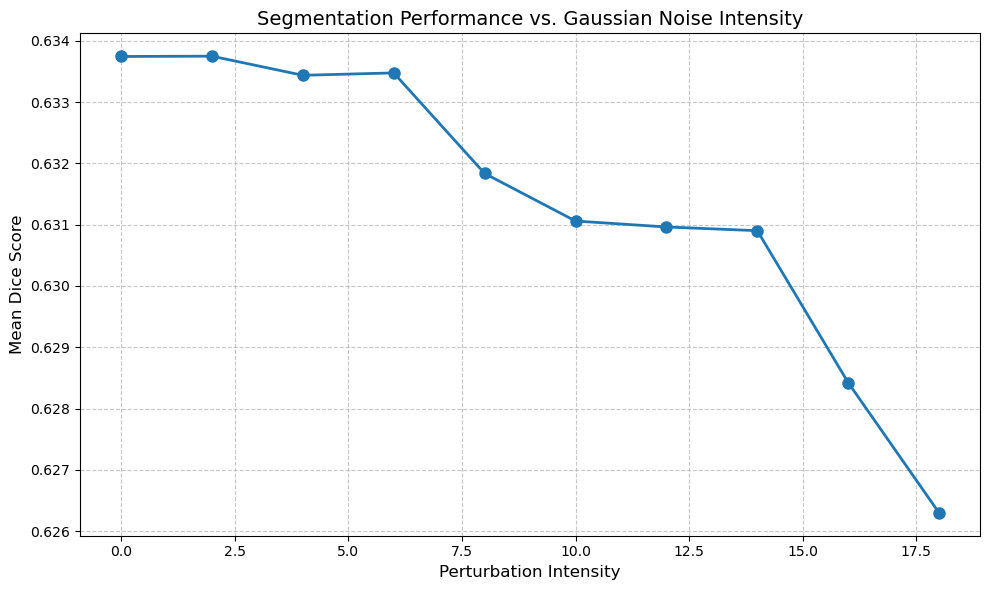

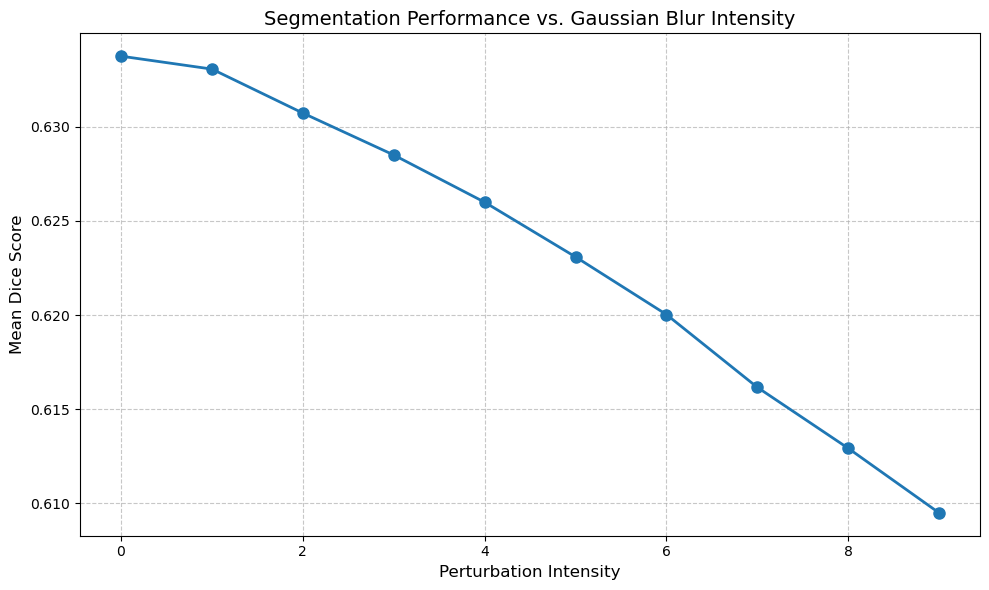

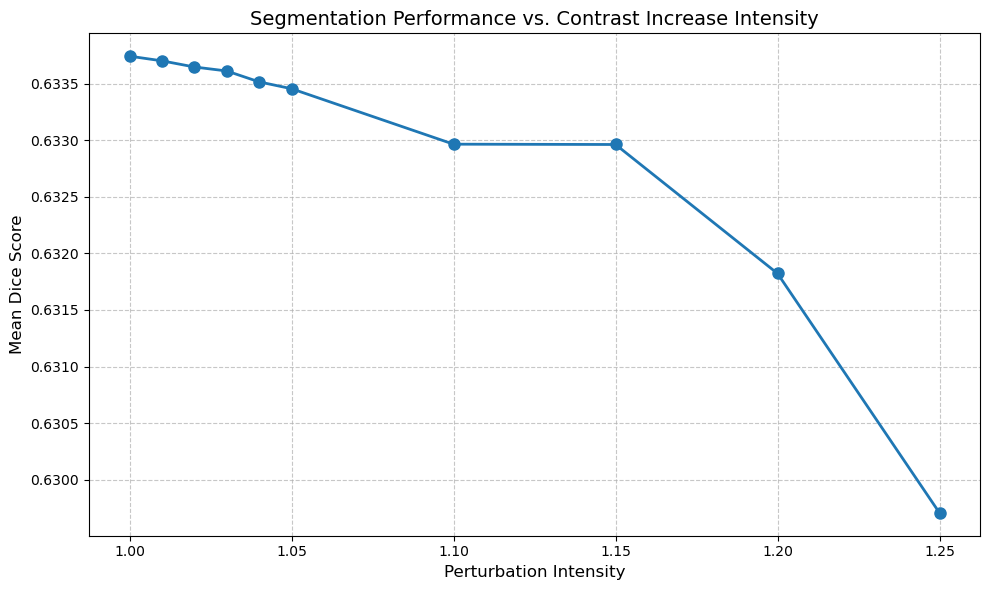

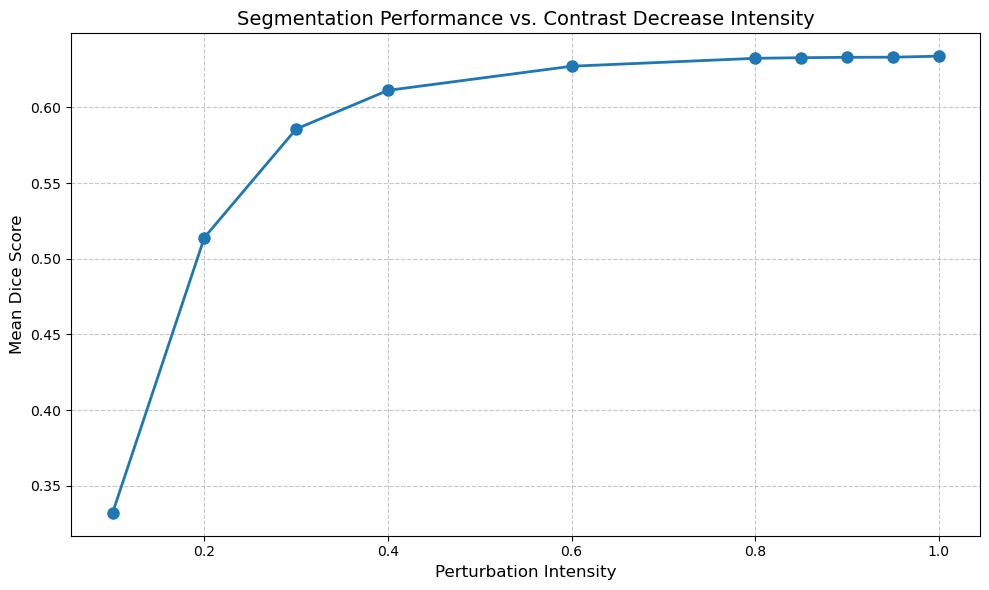

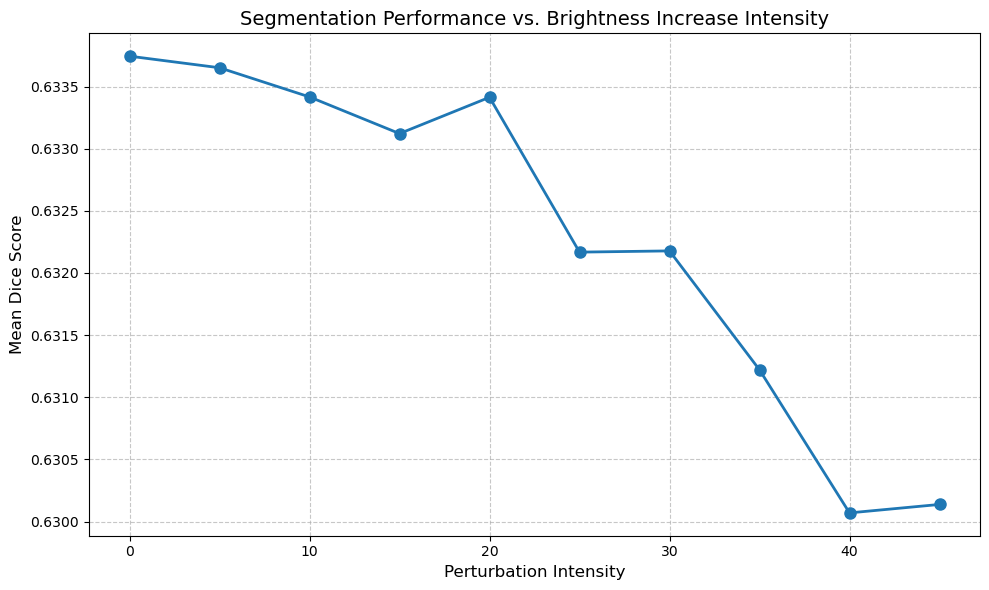

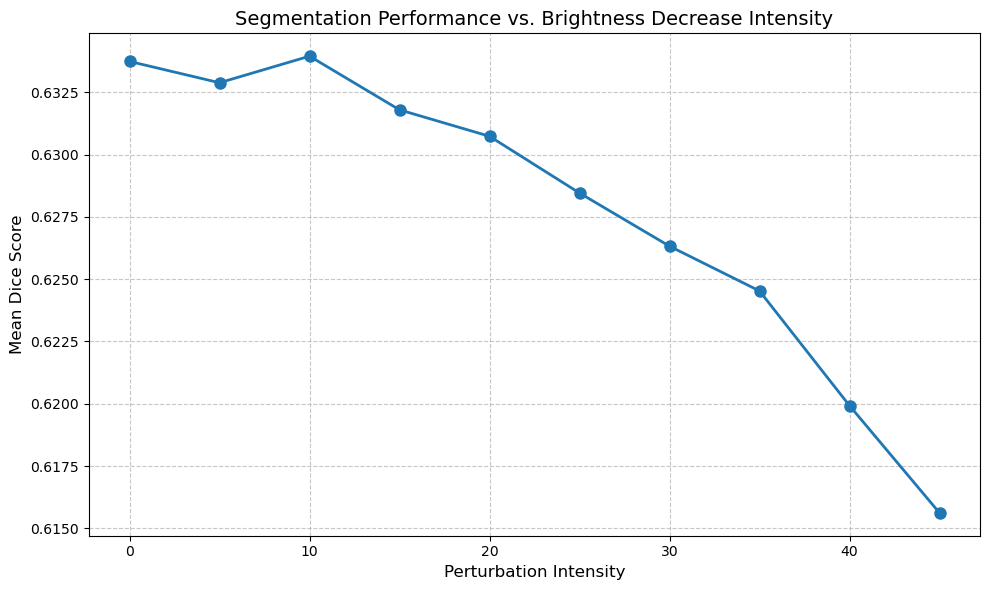

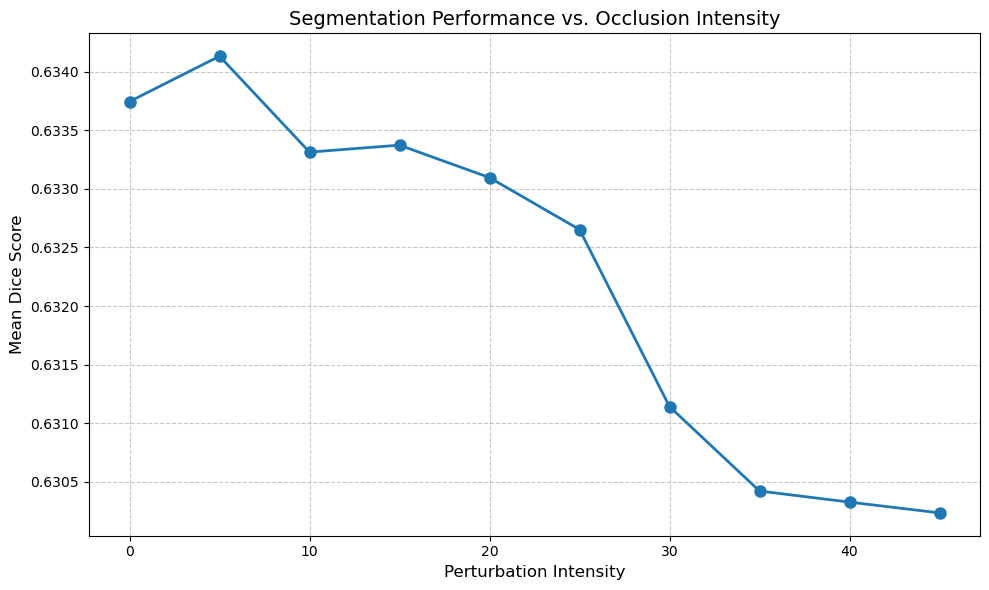

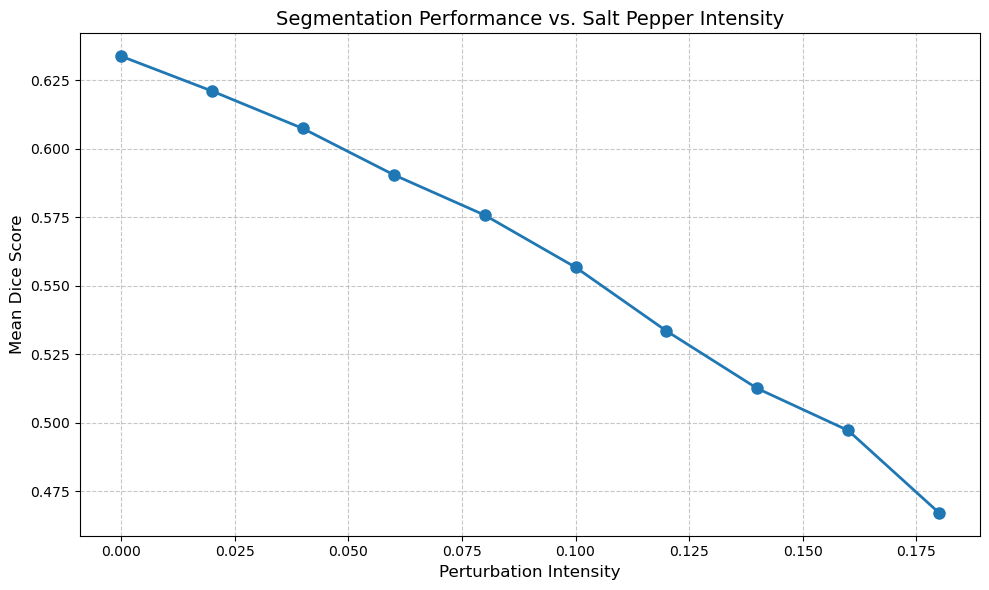

In [12]:
# Load results if we're running this cell separately
try:
    results = np.load(os.path.join(OUTPUT_DIR, 'perturbation_results.npy'), allow_pickle=True).item()
except:
    pass

# Create plots for each perturbation
plot_perturbation_results(results, OUTPUT_DIR)

# Display each perturbation plot
for perturbation in results.keys():
    plt.figure(figsize=(10, 6))
    
    # Get the intensity values for this perturbation
    intensity_values = dummy_dataset.intensity_values[perturbation]
    
    plt.plot(intensity_values, results[perturbation], 'o-', linewidth=2, markersize=8)
    plt.grid(True, linestyle='--', alpha=0.7)
    
    plt.title(f"Segmentation Performance vs. {perturbation.replace('_', ' ').title()} Intensity", fontsize=14)
    plt.xlabel("Perturbation Intensity", fontsize=12)
    plt.ylabel("Mean Dice Score", fontsize=12)
    
    plt.tight_layout()
    plt.show()

## 7. Combined Visualisation

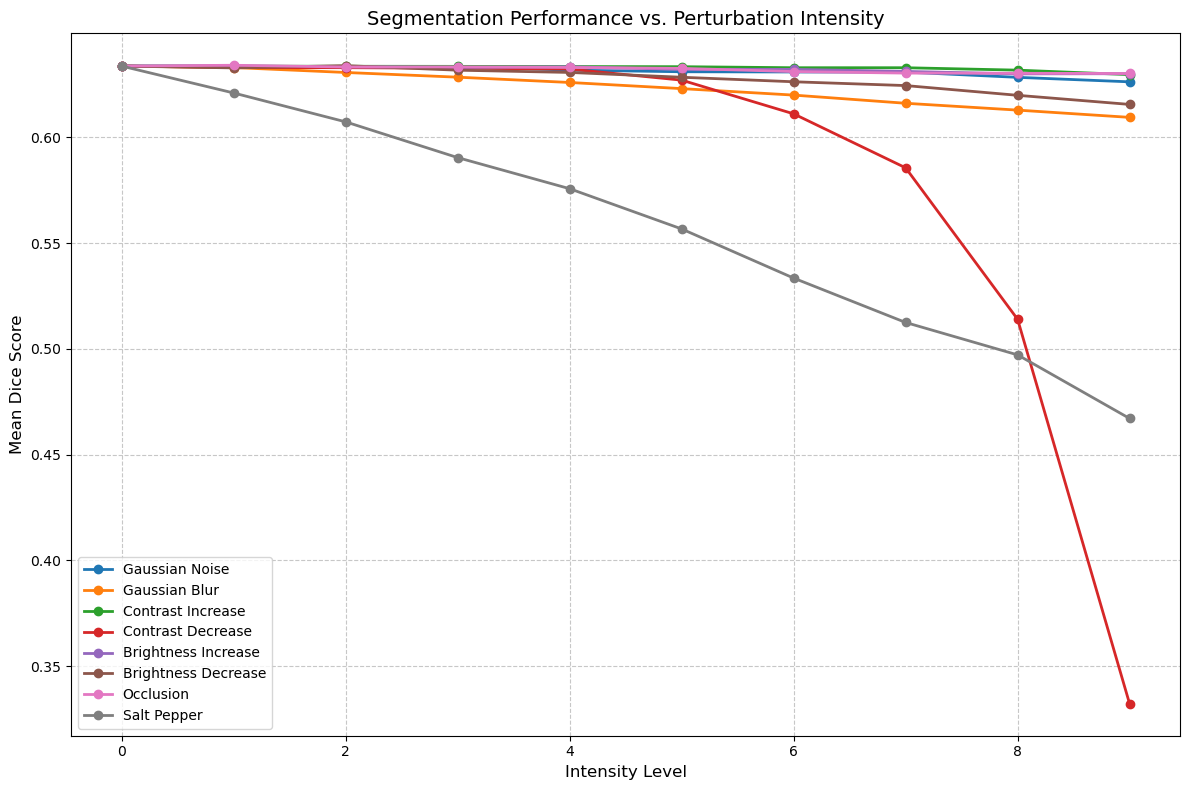

In [13]:
# Create a combined plot
plt.figure(figsize=(12, 8))

for perturbation, scores in results.items():
    # Use intensity level (0-9) for x-axis to make comparison easier
    intensity_level = list(range(len(scores)))
    
    plt.plot(intensity_level, scores, 'o-', linewidth=2, markersize=6, 
             label=perturbation.replace('_', ' ').title())

plt.grid(True, linestyle='--', alpha=0.7)
plt.title("Segmentation Performance vs. Perturbation Intensity", fontsize=14)
plt.xlabel("Intensity Level", fontsize=12)
plt.ylabel("Mean Dice Score", fontsize=12)
plt.legend(loc='best', fontsize=10)

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "combined_results.png"), dpi=300)
plt.show()

## 8. Analyse Impact of Different Perturbations

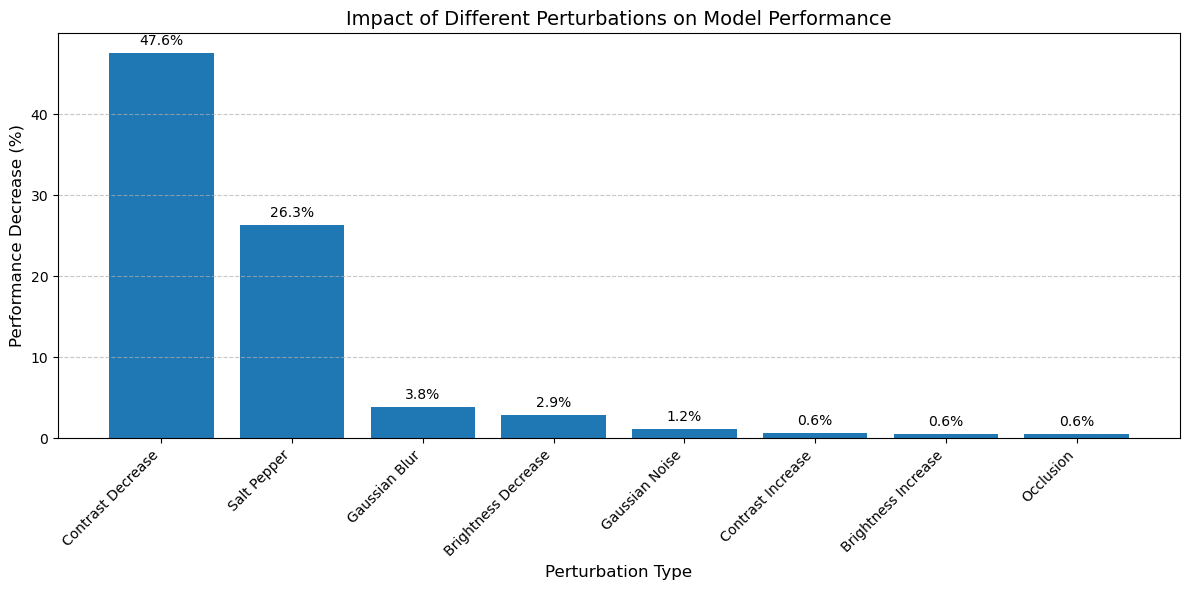

Ranking of perturbations by impact on model performance:
1. Contrast Decrease: 47.58% decrease in Dice score
2. Salt Pepper: 26.29% decrease in Dice score
3. Gaussian Blur: 3.83% decrease in Dice score
4. Brightness Decrease: 2.86% decrease in Dice score
5. Gaussian Noise: 1.18% decrease in Dice score
6. Contrast Increase: 0.64% decrease in Dice score
7. Brightness Increase: 0.57% decrease in Dice score
8. Occlusion: 0.55% decrease in Dice score


In [14]:
# Calculate the percentage decrease in performance for each perturbation
performance_decrease = {}

for perturbation, scores in results.items():
    # Initial score (no perturbation) vs. final score (max perturbation)
    initial_score = scores[0]
    final_score = scores[-1]
    
    # Calculate percentage decrease
    decrease = (initial_score - final_score) / initial_score * 100
    performance_decrease[perturbation] = decrease

# Sort perturbations by their impact
sorted_perturbations = sorted(performance_decrease.items(), key=lambda x: x[1], reverse=True)

# Visualize the results
plt.figure(figsize=(12, 6))
perturbations = [p[0].replace('_', ' ').title() for p in sorted_perturbations]
decreases = [p[1] for p in sorted_perturbations]

plt.bar(perturbations, decreases)
plt.title("Impact of Different Perturbations on Model Performance", fontsize=14)
plt.xlabel("Perturbation Type", fontsize=12)
plt.ylabel("Performance Decrease (%)", fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)

for i, v in enumerate(decreases):
    plt.text(i, v + 1, f"{v:.1f}%", ha='center')

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "perturbation_impact.png"), dpi=300)
plt.show()

# Print the ranking
print("Ranking of perturbations by impact on model performance:")
for i, (perturbation, decrease) in enumerate(sorted_perturbations):
    print(f"{i+1}. {perturbation.replace('_', ' ').title()}: {decrease:.2f}% decrease in Dice score")

## 9. Visualise Example Predictions

Visualizing predictions for contrast_decrease perturbation...


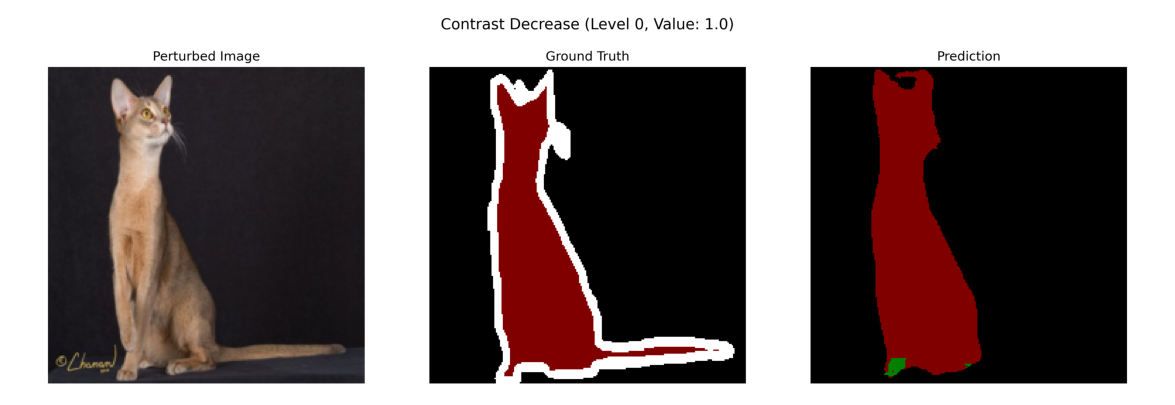

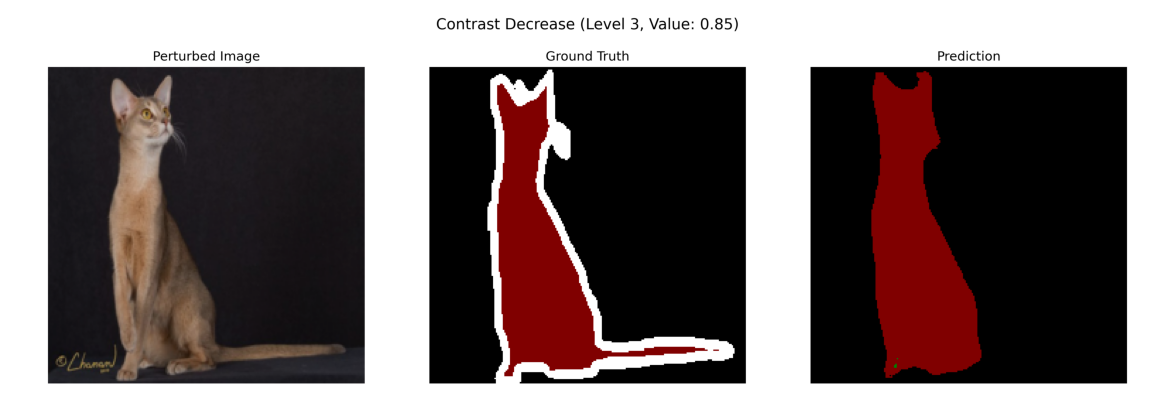

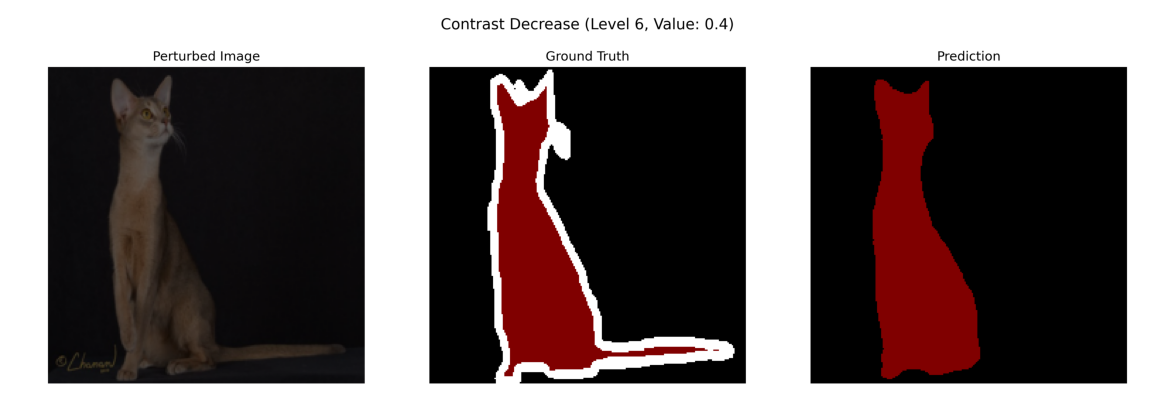

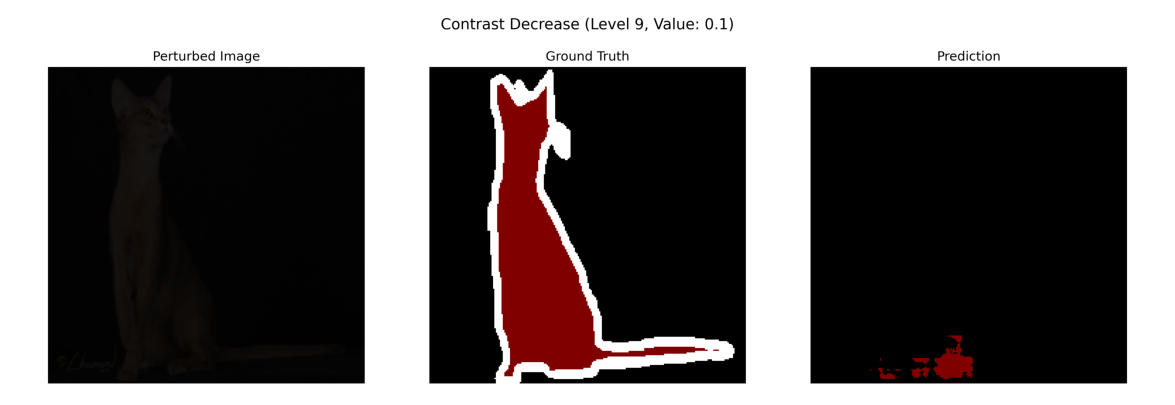

In [15]:
# Select a perturbation to visualize
# Pick the most impactful perturbation based on our analysis above
most_impactful_perturbation = sorted_perturbations[0][0]
print(f"Visualizing predictions for {most_impactful_perturbation} perturbation...")

# Create directory for visualization examples
viz_dir = os.path.join(OUTPUT_DIR, 'predictions')
os.makedirs(viz_dir, exist_ok=True)

# Visualize predictions at different intensity levels
visualize_predictions(
    model, 
    DATASET_ROOT, 
    most_impactful_perturbation, 
    levels=[0, 3, 6, 9],  # Original, mild, medium, and strong perturbation
    device=device,
    output_dir=viz_dir
)

# Display the images
for level in [0, 3, 6, 9]:
    img_path = os.path.join(viz_dir, f"{most_impactful_perturbation}_level_{level}.png")
    if os.path.exists(img_path):
        img = Image.open(img_path)
        plt.figure(figsize=(15, 5))
        plt.imshow(np.array(img))
        plt.axis('off')
        plt.show()

## 10. Visualise Another Important Perturbation

same for the second most impactful perturbation to get a broader understanding.

Visualizing predictions for salt_pepper perturbation...


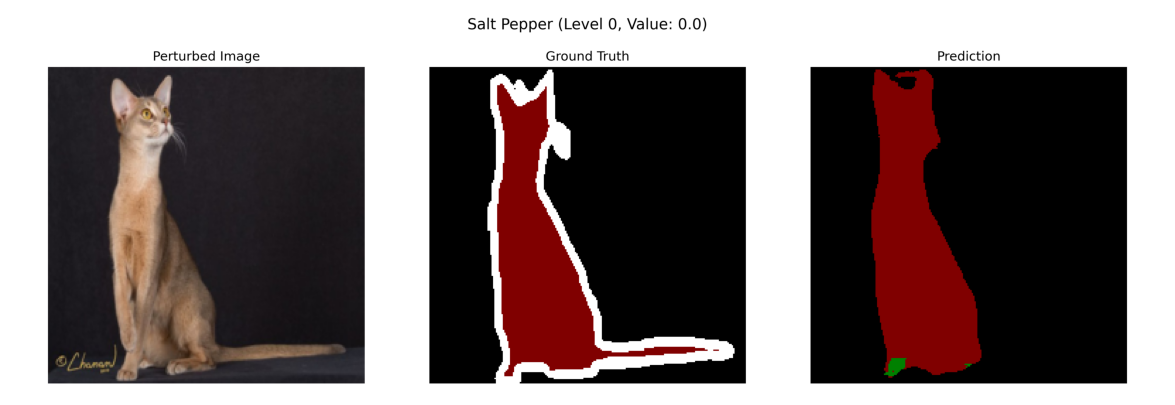

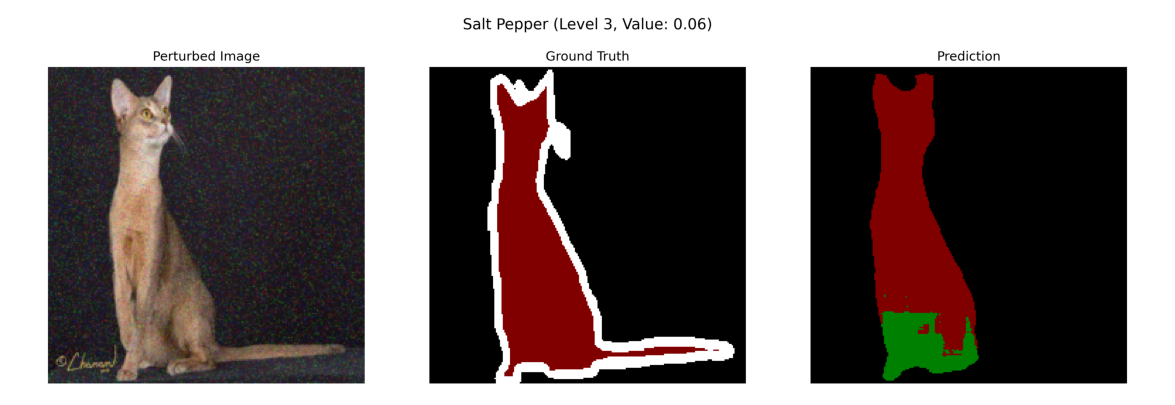

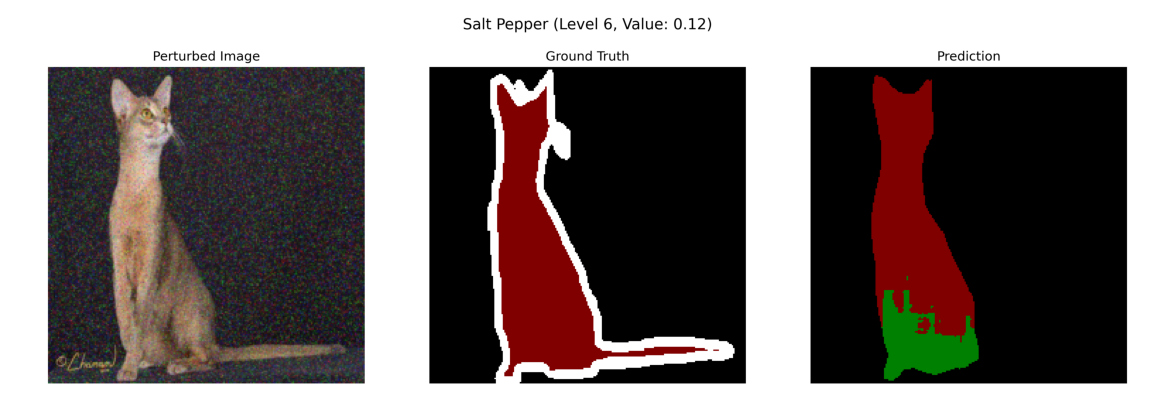

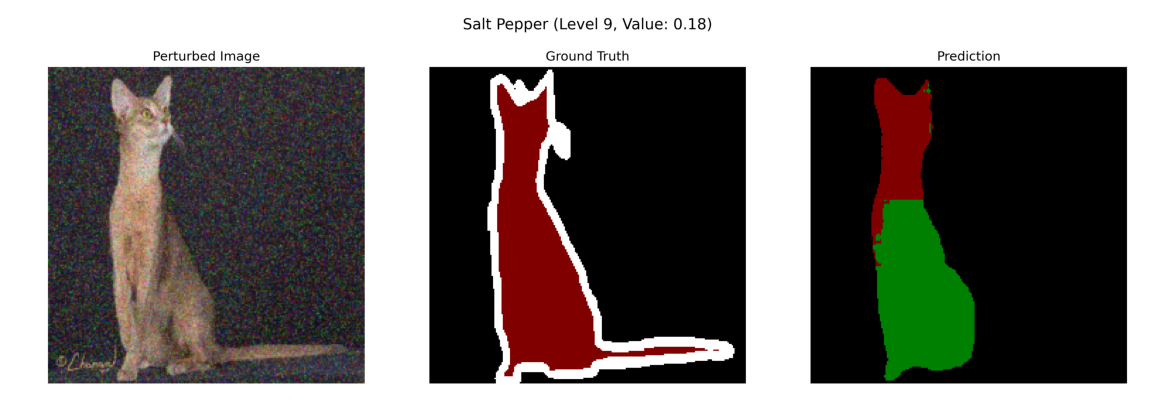

In [16]:
# Select the second most impactful perturbation
second_perturbation = sorted_perturbations[1][0]
print(f"Visualizing predictions for {second_perturbation} perturbation...")

# Visualize predictions at different intensity levels
visualize_predictions(
    model, 
    DATASET_ROOT, 
    second_perturbation, 
    levels=[0, 3, 6, 9],  # Original, mild, medium, and strong perturbation
    device=device,
    output_dir=viz_dir
)

# Display the images
for level in [0, 3, 6, 9]:
    img_path = os.path.join(viz_dir, f"{second_perturbation}_level_{level}.png")
    if os.path.exists(img_path):
        img = Image.open(img_path)
        plt.figure(figsize=(15, 5))
        plt.imshow(np.array(img))
        plt.axis('off')
        plt.show()

## 11. Conclusions

In [17]:
# Calculate key statistics for the report
init_scores = {p: scores[0] for p, scores in results.items()}
final_scores = {p: scores[-1] for p, scores in results.items()}
avg_init_score = np.mean(list(init_scores.values()))
avg_final_score = np.mean(list(final_scores.values()))
avg_decrease = (avg_init_score - avg_final_score) / avg_init_score * 100

print("Key Statistics:")
print(f"Average baseline Dice score (no perturbation): {avg_init_score:.4f}")
print(f"Average Dice score at maximum perturbation: {avg_final_score:.4f}")
print(f"Average performance decrease: {avg_decrease:.2f}%")
print("\nMost impactful perturbations:")
for i, (perturbation, decrease) in enumerate(sorted_perturbations[:3]):
    print(f"{i+1}. {perturbation.replace('_', ' ').title()}: {decrease:.2f}% decrease")

print("\nLeast impactful perturbations:")
for i, (perturbation, decrease) in enumerate(sorted_perturbations[-3:]):
    print(f"{i+1}. {perturbation.replace('_', ' ').title()}: {decrease:.2f}% decrease")

Key Statistics:
Average baseline Dice score (no perturbation): 0.6337
Average Dice score at maximum perturbation: 0.5676
Average performance decrease: 10.44%

Most impactful perturbations:
1. Contrast Decrease: 47.58% decrease
2. Salt Pepper: 26.29% decrease
3. Gaussian Blur: 3.83% decrease

Least impactful perturbations:
1. Contrast Increase: 0.64% decrease
2. Brightness Increase: 0.57% decrease
3. Occlusion: 0.55% decrease
